# Labeled Patent Dataset Exploration

## 1. Notebook Configuration

### 1.1. Loading Necessary Libraries

In [109]:
# General libraries:
import os
import glob
import numpy as np
import pandas as pd

# Dealing with images:
import cv2
import matplotlib.pyplot as plt

# Google APIs:
from google.cloud import bigquery

# Specific PDF libraries:
#!conda install -c conda-forge poppler
!sudo apt-get install -y poppler-data
!sudo apt-get install -y poppler-utils
!pip install pdf2image
from pdf2image import convert_from_path


Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-data is already the newest version (0.4.9-2).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libnspr4 libnss3 libpoppler82
The following NEW packages will be installed:
  libnspr4 libnss3 libpoppler82 poppler-utils
0 upgraded, 4 newly installed, 0 to remove and 9 not upgraded.
Need to get 2962 kB of archives.
After this operation, 8549 kB of additional disk space will be used.
Get:1 http://deb.debian.org/debian buster/main amd64 libnspr4 amd64 2:4.20-1 [112 kB]
Get:2 http://deb.debian.org/debian buster/main amd64 libnss3 amd64 2:3.42.1-1+deb10u3 [1159 kB]
Get:3 http://deb.debian.org/debian buster/main amd64 libpoppler82 amd64 0.71.0-5 [1507 kB]
Get:4 http://deb.debian.org/debian buster/main amd64 poppler-utils amd64 0.7

### 1.2. Setting Notebook Inputs

In [110]:
!gcloud config list

[ai]
region = us-central1
[core]
account = 1971106428-compute@developer.gserviceaccount.com
disable_usage_reporting = True
project = qwiklabs-gcp-00-7b6f768bf42d

Your active configuration is: [default]


In [111]:
PROJECT = 'qwiklabs-gcp-00-7b6f768bf42d'
REGION = 'us-central1'
BUCKET = 'labeled_patents'

os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['BUCKET'] = BUCKET

In [70]:
pd.set_option('expand_frame_repr', False)

## 2. Loading the Labeled Patent Public Dataset Tables

### 2.1. Creating the BigQuery Dataset

In [ ]:
%%bash
# Create a BigQuery dataset for the labeled patents dataset if it doesn't exist:
datasetexists=$(bq ls -d | grep -w labeled_patents)

if [ -n "$datasetexists" ]; then
    echo -e "BigQuery dataset already exists, let's not recreate it."
    echo "Here are your current datasets:"
    bq ls
else
    echo "Creating BigQuery dataset titled: labeled_patents"
    
    bq --location=US mk --dataset \
        --description "Labeled Patents" \
        $PROJECT:labeled_patents
    echo "Here are your current datasets:"
    bq ls
fi

In [28]:
%%bigquery
# Creating the "figures" table for object detection:
CREATE OR REPLACE TABLE
    labeled_patents.figures AS
SELECT
    *
FROM
    bigquery-public-data.labeled_patents.figures

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1924.29query/s]                        


""


In [29]:
%%bigquery
# Creating the "extracted_data" table for entity recognition:
CREATE OR REPLACE TABLE
    labeled_patents.extracted_data AS
SELECT
    *
FROM
    bigquery-public-data.labeled_patents.extracted_data

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1964.55query/s]                        


""


In [30]:
%%bigquery
# Creating the "invention_types" table document classification:
CREATE OR REPLACE TABLE
    labeled_patents.invention_types AS
SELECT
    *
FROM
    bigquery-public-data.labeled_patents.invention_types

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 2252.58query/s]                        


""


## 3. Exploring the Dataset Tables as Pandas Dataframes

In [ ]:
# Creating a BigQuery client:
bq = bigquery.Client()

### 3.1. Exploring "Figures" Table

In [33]:
# Loading "figures" table into a dataframe:
query = """
SELECT
    *
FROM
    labeled_patents.figures
"""
figures_df = bq.query(query).to_dataframe()
print('Dataset shape: {:d}x{:d}'.format(*figures_df.shape))
figures_df.head()

Dataset shape: 91x5


,gcs_path,x_relative_min,y_relative_min,x_relative_max,y_relative_max
0,gs://gcs-public-data--labeled-patents/espacene...,0.356322,0.745275,0.669691,0.936856
1,gs://gcs-public-data--labeled-patents/espacene...,0.358137,0.637457,0.664247,0.935567
2,gs://gcs-public-data--labeled-patents/espacene...,0.395039,0.682131,0.640048,0.935567
3,gs://gcs-public-data--labeled-patents/espacene...,0.539020,0.600945,0.882638,0.955326
4,gs://gcs-public-data--labeled-patents/espacene...,0.531155,0.597079,0.888082,0.923110


In [36]:
# Number of unique values of the images:
n = figures_df['gcs_path'].unique().shape[0]
print('Number of unique images in "gcs_path" column: {:d}'.format(n))

figures_df.describe().transpose()

Number of unique images in "gcs_path" column: 91


,count,mean,std,min,25%,50%,75%,max
x_relative_min,91.0,0.384004,0.141596,0.124622,0.264670,0.335148,0.534180,0.616455
y_relative_min,91.0,0.640960,0.066183,0.511168,0.584837,0.645189,0.699098,0.766323
x_relative_max,91.0,0.800031,0.081475,0.625529,0.736237,0.798548,0.883545,0.904416
y_relative_max,91.0,0.920575,0.046000,0.734107,0.906572,0.940722,0.950172,0.960052


The table "figures" has 91 rows (one per image). Each row contains one box coordinates and the image to which the box corresponds.
Each row has five columns:
 - gcs_path: image to which the box corresponds.
 - x_relative_min: horizontal coordinate of the top left corner of the box, adimensionalized with image width.
 - y_relative_min: vertical coordinate of the top left corner of the box, adimensionalized with image height.
 - x_relative_max: horizontal coordinate of the bottom right corner of the box, adimensionalized with image width.
 - y_relative_max: vertical coordinate of the bottom right corner of the box, adimensionalized with image height.

### 3.2. Exploring "Invention_Types" Table

In [38]:
# Loading "figures" table into a dataframe:
query = """
SELECT
    *
FROM
    labeled_patents.invention_types
"""
invtypes_df = bq.query(query).to_dataframe()
print('Dataset shape: {:d}x{:d}'.format(*invtypes_df.shape))
invtypes_df.head()

Dataset shape: 136x2


,gcs_path,invention_type
0,gs://gcs-public-data--labeled-patents/us_057.pdf,other
1,gs://gcs-public-data--labeled-patents/us_051.pdf,other
2,gs://gcs-public-data--labeled-patents/us_074.pdf,other
3,gs://gcs-public-data--labeled-patents/us_058.pdf,other
4,gs://gcs-public-data--labeled-patents/us_064.pdf,other


In [49]:
aux_df = invtypes_df['invention_type'].value_counts()

other              76
crypto             20
med_tech           20
computer_vision    20
Name: invention_type, dtype: int64


In [51]:
# Number of unique values of the images:
n = invtypes_df['gcs_path'].unique().shape[0]
print('Number of unique images in "gcs_path" column: {:d}'.format(n))

print('Types of inventions of the documents: value + amount')
print(invtypes_df['invention_type'].value_counts())

Number of unique images in "gcs_path" column: 136
Types of inventions of the documents: value + amount
other              76
crypto             20
med_tech           20
computer_vision    20
Name: invention_type, dtype: int64


The table "inventions_type" has 136 rows (one per image). Each row contains the file name (and path) of the patent and the type of invention according to four types of inventions:
 - crypto: 20 patents
 - med_tech: 20 patents
 - computer_vision: 20 patents
 - others: 76 patents
 
It is worth noting that there is information for 136 patents in this table, but we have only box coordinates in the "figures" table for 91 patents.

### 3.3. Exploring "Extracted Data" Table

In [53]:
# Loading "extracted_data" table into a dataframe:
query = """
SELECT
    *
FROM
    labeled_patents.extracted_data
"""
extdata_df = bq.query(query).to_dataframe()
print('Dataset shape: {:d}x{:d}'.format(*extdata_df.shape))
extdata_df.head()

Dataset shape: 343x14


,gcs_path,issuer,language,publication_date,class_international,class_us,application_number,filing_date,priority_date_eu,representative_line_1_eu,applicant_line_1,inventor_line_1,title_line_1,number
0,gs://gcs-public-data--labeled-patents/espacene...,EU,DE,29.08.018,E04H 6/12,None,18157874.1,21.02.2018,22.02.2017,Liedtke & Partner Patentanw√§lte,SHB Hebezeugbau GmbH,"VOLGER, Alexander",STEUERUNGSSYSTEM F√úR AUTOMATISCHE PARKH√ÑUSER,EP 3 366 869 A1
1,gs://gcs-public-data--labeled-patents/espacene...,EU,DE,03.10.2018,H01L 21/20,None,18166536.5,16.02.2016,None,"Scheider, Sascha et al",EV Group E. Thallner GmbH,"Kurz, Florian",VORRICHTUNG ZUM BONDEN VON SUBSTRATEN,EP 3 382 744 A1
2,gs://gcs-public-data--labeled-patents/espacene...,EU,DE,03.10.2018,G09B 9/04,None,18162935.3,20.03.2018,31.03.2017,v. Bezold & Partner Patentanw√§lte,MAN Truck & Bus AG,"Mohra, Holger",TECHNIK ZUR EINBEZIEHUNG EINER BEDIENUNGSANLEI...,EP 3 382 675 A1
3,gs://gcs-public-data--labeled-patents/espacene...,EU,DE,03.10.2018,H05B 6/12,None,18165514.3,03.04.2018,30.03.2017,None,BSH Hausger√§te GmbH,"Acero Acero, Jesus",VORRICHTUNG ZUR INDUKTIVEN ENERGIE√úBERTRAGUNG,EP 3 383 141 A2
4,gs://gcs-public-data--labeled-patents/espacene...,EU,DE,03.10.2018,H05B 6/12,None,18165513.5,03.04.2018,30.03.2017,None,BSH Hausger√§te GmbH,"Acero Acero, Jesus",VORRICHTUNG ZUR INDUKTIVEN ENERGIE√úBERTRAGUNG,EP 3 383 140 A1


In [54]:
print('Columns in the "extracted data" table:')
print(extdata_df.columns)

Columns in the "extracted data" table:
Index(['gcs_path', 'issuer', 'language', 'publication_date',
       'class_international', 'class_us', 'application_number', 'filing_date',
       'priority_date_eu', 'representative_line_1_eu', 'applicant_line_1',
       'inventor_line_1', 'title_line_1', 'number'],
      dtype='object')


In [57]:
# Number of unique values of the images:
n = extdata_df['gcs_path'].unique().shape[0]
print('Number of unique images in "gcs_path" column: {:d}'.format(n))

# How many patents are from US and how many from EU?
print('Number of patents per issuer: US/EU')
print(extdata_df['issuer'].value_counts())

# How many patents are from language?
print('Number of patents per language')
print(extdata_df['language'].value_counts())




Number of unique images in "gcs_path" column: 343
Number of patents per issuer: US/EU
EU    246
US     97
Name: issuer, dtype: int64
Number of patents per language
EN    197
FR     83
DE     63
Name: language, dtype: int64


In [71]:
# How format of some entities change depending on US/EU and language?
samp_n = 5
cols = ['gcs_path', 'language', 'class_us', 'class_international', 'application_number']

# Sample of US patents:
filtidx = extdata_df['issuer']=='US'
print(extdata_df.loc[filtidx, cols].head(samp_n))

# Sample of EU patents in English:
filtidx = (extdata_df['issuer']=='EU') & (extdata_df['language']=='EN')
print(extdata_df.loc[filtidx, cols].head(samp_n))
                         
# Sample of EU patents in French:
filtidx = (extdata_df['issuer']=='EU') & (extdata_df['language']=='FR')
print(extdata_df.loc[filtidx, cols].head(samp_n))

# Sample of EU patents in German:
filtidx = (extdata_df['issuer']=='EU') & (extdata_df['language']=='DE')
print(extdata_df.loc[filtidx, cols].head(samp_n))


                                             gcs_path language     class_us class_international application_number
163  gs://gcs-public-data--labeled-patents/us_006.pdf       EN    H04W 4/12           H04W 4/00         14/619,918
164  gs://gcs-public-data--labeled-patents/us_009.pdf       EN   H04S 7/303           H04R 5/02         15/568,451
165  gs://gcs-public-data--labeled-patents/us_007.pdf       EN   H04W 4/043          H04W 24/00         15/263,314
166  gs://gcs-public-data--labeled-patents/us_001.pdf       EN  H04W 64/003          H04W 64/00         15/679,694
167  gs://gcs-public-data--labeled-patents/us_005.pdf       EN    H04W 4/80           H04W 4/80         15/625,786
                                             gcs_path language class_us class_international application_number
63  gs://gcs-public-data--labeled-patents/espacene...       EN     None          H04L 12/28         16924214.6
64  gs://gcs-public-data--labeled-patents/espacene...       EN     None           G06F 3

The table "extracted_data" has 343 rows (one per image). Each row contains the file name (and path) of the patent and the value of several entities of interest.

In this table there are 246 patents from Europe and just 97 patents from the US. The distribution according to languages and issuer is shown next:
 - US-EN:  97 patents
 - EU-EN: 100 patents
 - EU-FR:  83 patents
 - EU-DE:  63 patents

Another important aspect to take into account for entity extraction is that it seems that there is no rule that affects nor the application_number, neither the class_international depending on the issuer or language. Finally, another challenge will be distinguish between the "class_international" and "class_us" codes in the US patents, since it seems they have the same format.

In [ ]:
# 4. Creating a Bucket to Store PDFs and CSVs

In [73]:
%%bash
## Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
    echo "Here are your current buckets:"
    gsutil ls
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "Here are your current buckets:"
    gsutil ls
fi

Bucket exists, let's not recreate it.
Here are your current buckets:
gs://artifacts.qwiklabs-gcp-00-7b6f768bf42d.appspot.com/
gs://cloud-ai-platform-56837b24-7d4e-4ad2-ae32-86a05972f71e/
gs://labeled_patents/
gs://qwiklabs-gcp-00-7b6f768bf42d/


## 5. Copying the Patents PDFs into our Bucket and into Disk

In [92]:
# Copying pdfs into the project bucket:
!gsutil -m cp gs://gcs-public-data--labeled-patents/*.pdf  gs://labeled_patents/pdf

Copying gs://gcs-public-data--labeled-patents/computer_vision_1.pdf [Content-Type=application/pdf]...
Copying gs://gcs-public-data--labeled-patents/computer_vision_11.pdf [Content-Type=application/pdf]...
Copying gs://gcs-public-data--labeled-patents/computer_vision_10.pdf [Content-Type=application/pdf]...
Copying gs://gcs-public-data--labeled-patents/computer_vision_12.pdf [Content-Type=application/pdf]...
Copying gs://gcs-public-data--labeled-patents/computer_vision_14.pdf [Content-Type=application/pdf]...
Copying gs://gcs-public-data--labeled-patents/computer_vision_15.pdf [Content-Type=application/pdf]...
Copying gs://gcs-public-data--labeled-patents/computer_vision_17.pdf [Content-Type=application/pdf]...
Copying gs://gcs-public-data--labeled-patents/computer_vision_13.pdf [Content-Type=application/pdf]...
Copying gs://gcs-public-data--labeled-patents/computer_vision_18.pdf [Content-Type=application/pdf]...
Copying gs://gcs-public-data--labeled-patents/computer_vision_16.pdf [Cont

In [ ]:
# Create first a "dataset/pdf" folder:
!gsutil -m cp gs://labeled_patents/pdf/*.pdf  ./dataset/pdf

In [ ]:
import glob

pdf_lst = glob.glob("./dataset/pdf/*.pdf)

In [88]:
!pip install pdf2image

import cv2
from pdf2image import convert_from_path

In [112]:
path = r'./dataset/pdf/computer_vision_1.pdf'
page_lst = convert_from_path(path)
print(page_lst)

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200 at 0x7FCFA54F3910>]


In [119]:
for img in page_lst:
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
print('Image dimensions: {:d}x{:d}'.format(*img.shape))
print('Image pixel max. value: {:2.2f}'.format(img.max()))
print('Image pixel min. value: {:2.2f}'.format(img.min()))

Image dimensions: 2200x1700
Image pixel max. value: 255.00
Image pixel min. value: 0.00


(-0.5, 1699.5, 2199.5, -0.5)

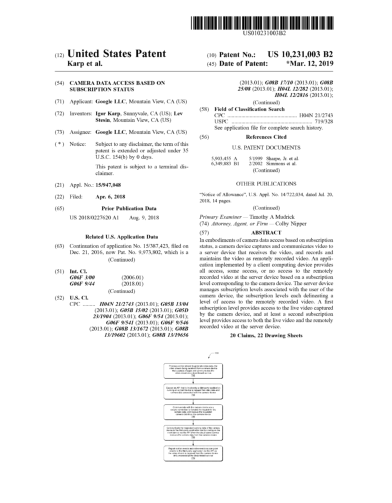

In [122]:
h_fig = 12
w_fig = int(h_fig * img.shape[1] / img.shape[0])
plt.figure(figsize=(h_fig, w_fig))
plt.imshow(img, cmap='gray')
plt.axis('off')

### X.X. Export from BigQuery to CSVs in GCS

In [ ]:
# Construct a BigQuery client object.
client = bigquery.Client()

dataset_name = "babyweight"

# Create dataset reference object
dataset_ref = client.dataset(
    dataset_id=dataset_name, project=client.project)

# Export both train and eval tables
for step in ["train", "eval"]:
    destination_uri = os.path.join(
        "gs://", BUCKET, dataset_name, "data", "{}*.csv".format(step))
    table_name = "babyweight_data_{}".format(step)
    table_ref = dataset_ref.table(table_name)
    extract_job = client.extract_table(
        table_ref,
        destination_uri,
        # Location must match that of the source table.
        location="US",
    )  # API request
    extract_job.result()  # Waits for job to complete.

    print("Exported {}:{}.{} to {}".format(
        client.project, dataset_name, table_name, destination_uri))